# ST2MLE : Machine Learning for IT Engineers Project
## Machine Learning Project – Numerical and Textual Data (French Context)
### Context
As part of this project, students will work on mixed data (numerical and textual) collected from French websites.
The objective is to carry out a comprehensive analysis, from data collection to modeling
and interpretation, with a focus on a French economic, social, or public context.

### Learning Objectives
- Master the full lifecycle of a data project (collection, cleaning, preprocessing, modeling, evaluation).
- Apply techniques for text processing and numerical data analysis.
- Explore various text vectorization techniques (BoW, TF-IDF, Doc2Vec, BERT).
- Conduct analyses and provide recommendations based on real French data.

### Project Steps
1. Define a topic, the needs and identify relevant French sources.
2. Collect data (web scraping, APIs...).
3. Clean and preprocess both numerical and textual data.
4. Annotate (label) data. Some websites already include categories or tags — these can be scraped alongside the text and used as labels. Otherwise, label data manually.
5. Perform exploratory analysis and visualizations (distributions, word clouds, correlations...) to check for outliers, class imbalance, etc.
6. Apply under-sampling or oversampling (if needed), PCA for feature extraction (if needed).
7. Apply predictive models:
  - **Numerical data**: Decision Trees, Random Forest, Boosting.
  - **Textual data**: Naive Bayes, Logistic Regression after vectorization.
8. Compare text vectorization methods: BoW, TF-IDF, Doc2Vec, BERT.
9. Provide business recommendations and submit a final report.

### Technical Constraints
- Data must be exclusively from French sources.
- Texts must be in French only (use appropriate preprocessing: French lemmatization, French stopwords).
- Minimum of 500 data rows.
- Implementation in Python using scikit-learn, gensim, transformers, etc.

### Evaluation Criteria
- Quality and relevance of data collection and labeling (10%)
- Quality of data cleaning and preprocessing (10%)
- Relevance of visualizations and exploratory analysis (10%)
- Implementation of models (30%)
- Comparison and discussion of vectorization techniques (10%)
- Recommendations and critical thinking (10%)
- Quality of the report and code (5%)
- Quality of the presentation (5%)
- Q&A (10%)

In [1]:
import numpy as np

# Import data from CSV file

import pandas as pd

# Load the CSV file
df = pd.read_csv('data/classements_letudiant.csv')

# Display information of dataset
df.info()

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10773 entries, 0 to 10772
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   École          10773 non-null  object
 1   Thématique     10773 non-null  object
 2   ID Thématique  10773 non-null  int64 
 3   Critère        10773 non-null  object
 4   Score /10      817 non-null    object
 5   Note brute     10771 non-null  object
dtypes: int64(1), object(5)
memory usage: 505.1+ KB


,École,Thématique,ID Thématique,Critère,Score /10,Note brute
0,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Présence sur Parcoursup,NaN,Oui
1,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Villes d'implantation de l'école en France,NaN,Palaiseau
2,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Statut de l'école,NaN,Public
3,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Ministère de tutelle,NaN,Ministère des Armées
4,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Concours,NaN,X-ESPCI
...,...,...,...,...,...,...
10768,Polytech Sorbonne,Professionnalisation et emploi,431,"Autres industries (bois, imprimerie...)",NaN,Non communiqué
10769,Polytech Sorbonne,Professionnalisation et emploi,431,Métiers de l'eau et gestion des déchets (achem...,NaN,Non communiqué
10770,Polytech Sorbonne,Professionnalisation et emploi,431,Commerce,NaN,Non communiqué
10771,Polytech Sorbonne,Professionnalisation et emploi,431,Télécommunications,NaN,Non communiqué


In [2]:
df.columns = (
    df.columns.str.lower()
    .str.strip()
    .str.replace(" /10", "")
    .str.replace(" ", "_")
    .str.replace("é", "e")
    .str.replace("è", "e")
)

df

,ecole,thematique,id_thematique,critere,score,note_brute
0,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Présence sur Parcoursup,NaN,Oui
1,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Villes d'implantation de l'école en France,NaN,Palaiseau
2,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Statut de l'école,NaN,Public
3,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Ministère de tutelle,NaN,Ministère des Armées
4,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Concours,NaN,X-ESPCI
...,...,...,...,...,...,...
10768,Polytech Sorbonne,Professionnalisation et emploi,431,"Autres industries (bois, imprimerie...)",NaN,Non communiqué
10769,Polytech Sorbonne,Professionnalisation et emploi,431,Métiers de l'eau et gestion des déchets (achem...,NaN,Non communiqué
10770,Polytech Sorbonne,Professionnalisation et emploi,431,Commerce,NaN,Non communiqué
10771,Polytech Sorbonne,Professionnalisation et emploi,431,Télécommunications,NaN,Non communiqué


In [3]:
# Remove /10 /2 in scores
# Remove % in scores
df["score"] = (
    df["score"]
    .astype(str)
    .str.replace(r"/\d+", "", regex=True)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

df

,ecole,thematique,id_thematique,critere,score,note_brute
0,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Présence sur Parcoursup,NaN,Oui
1,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Villes d'implantation de l'école en France,NaN,Palaiseau
2,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Statut de l'école,NaN,Public
3,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Ministère de tutelle,NaN,Ministère des Armées
4,École Polytechnique - Palaiseau,Mieux connaître l'école,425,Concours,NaN,X-ESPCI
...,...,...,...,...,...,...
10768,Polytech Sorbonne,Professionnalisation et emploi,431,"Autres industries (bois, imprimerie...)",NaN,Non communiqué
10769,Polytech Sorbonne,Professionnalisation et emploi,431,Métiers de l'eau et gestion des déchets (achem...,NaN,Non communiqué
10770,Polytech Sorbonne,Professionnalisation et emploi,431,Commerce,NaN,Non communiqué
10771,Polytech Sorbonne,Professionnalisation et emploi,431,Télécommunications,NaN,Non communiqué


In [4]:
# Pivot table
df = df.pivot_table(
    index="ecole", columns="critere", values=["score", "note_brute"], aggfunc="first"
).sort_index()

df

note_brute  \
critere                                            Accord de Grenoble   
ecole                                                                   
3iL ingénieurs                                                    Non   
AgroParisTech                                                     Oui   
Arts et Métiers Sciences et Technologies                          Oui   
Bordeaux Sciences Agro                                            Oui   
Builders École d’ingénieurs                                       Non   
...                                                               ...   
École des Mines Paris - PSL                                       Non   
École des mines - Nancy                                           Non   
École des mines - Saint-Étienne                                   Oui   
École nationale des ponts et chaussées - Marne-...                Oui   
École supérieure du bois - Nantes                                 Non   

                                                                                                      \
critere                                            Activités informatiques et services d'information   
ecole                                                                                                  
3iL ingénieurs                                                                                12,04%   
AgroParisTech                                                                                  0,46%   
Arts et Métiers Sciences et Technologies                                                       6,49%   
Bordeaux Sciences Agro                                                                         0,00%   
Builders École d’ingénieurs                                                                    0,00%   
...                                                                                              ...   
École des Mines Paris - PSL                                                                    9,48%   
École des mines - Nancy                                                                       24,27%   
École des mines - Saint-Étienne                                                       Non communiqué   
École nationale des ponts et chaussées - Marne-...                                             4,85%   
École supérieure du bois - Nantes                                                              0,00%   

                                                                                                                   \
critere                                            Administration d'Etat, Collectivité territoriale, Hospitalière   
ecole                                                                                                               
3iL ingénieurs                                                                                  0,00%               
AgroParisTech                                                                                  14,22%               
Arts et Métiers Sciences et Technologies                                                        1,18%               
Bordeaux Sciences Agro                                                                          6,02%               
Builders École d’ingénieurs                                                                     0,00%               
...                                                                                               ...               
École des Mines Paris - PSL                                                                     6,90%               
École des mines - Nancy                                                                         0,97%               
École des mines - Saint-Étienne                                                        Non communiqué               
École nationale des ponts et chaussées - Marne-...                                              4,85%               
École supérieure du bois - Nantes                         

In [5]:
df.columns = [f"{v}_{c}".lower().replace(" ", "_") for v, c in df.columns]

df.reset_index(inplace=True)

df

,ecole,note_brute_accord_de_grenoble,note_brute_activités_informatiques_et_services_d'information,"note_brute_administration_d'etat,_collectivité_territoriale,_hospitalière","note_brute_agriculture,_sylviculture,_pêche","note_brute_autres_industries_(bois,_imprimerie...)",note_brute_autres_secteurs,"note_brute_btp,_construction",note_brute_cellule_de_soutien_psychologique,note_brute_commerce,...,score_moyenne_au_bac_des_intégrés,score_ouverture_sociale,score_parité_au_sein_de_la_promotion_(hommes/femmes),score_part_d'enseignants-chercheurs,score_politique_de_chaires,score_pourcentage_d'étudiants_internationaux,score_pourcentage_de_double_diplômés_internationaux,score_réputation_internationale,score_salaire_à_la_sortie,score_taux_d'alternants
0,3iL ingénieurs,Non,"12,04%","0,00%","2,78%","0,93%","56,48%","0,93%",Oui,"1,85%",...,NaN,NaN,NaN,NaN,NaN,9.5,9.5,NaN,8.0,5.0
1,AgroParisTech,Oui,"0,46%","14,22%","28,44%","0,46%","8,26%","0,92%",Oui,"2,29%",...,8.0,NaN,2.0,9.0,8.0,NaN,NaN,10.0,NaN,NaN
2,Arts et Métiers Sciences et Technologies,Oui,"6,49%","1,18%","0,88%","7,37%","10,03%","12,68%",Oui,"1,47%",...,NaN,6.5,NaN,NaN,NaN,NaN,8.0,7.5,8.0,NaN
3,Bordeaux Sciences Agro,Oui,"0,00%","6,02%","45,78%","1,20%","22,89%","1,20%",Oui,"2,41%",...,NaN,6.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Builders École d’ingénieurs,Non,"0,00%","0,00%","0,00%","0,00%","0,00%","100,00%",Non,"0,00%",...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,8.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,École des Mines Paris - PSL,Non,"9,48%","6,90%","0,00%","2,59%","37,07%","0,00%",Oui,"0,00%",...,10.0,NaN,NaN,10.0,10.0,NaN,7.0,9.0,10.0,NaN
167,École des mines - Nancy,Non,"24,27%","0,97%","0,97%","0,00%","20,39%","5,83%",Oui,"0,97%",...,10.0,NaN,NaN,9.5,8.0,NaN,9.0,7.0,9.0,NaN
168,École des mines - Saint-Étienne,Oui,Non communiqué,Non communiqué,Non communiqué,Non communiqué,Non communiqué,Non communiqué,Oui,Non communiqué,...,10.0,NaN,NaN,9.5,NaN,NaN,8.0,NaN,9.0,NaN
169,École nationale des ponts et chaussées - Marne...,Oui,"4,85%","4,85%","0,44%","1,32%","16,74%","17,18%",Oui,"2,20%",...,10.0,NaN,NaN,9.5,9.0,7.0,NaN,7.5,10.0,NaN


In [6]:
# Delete specific columns
columns_to_drop = [
    "note_brute_origine_des_intégrés_en_cycle_ingénieur",
    "note_brute_nombre_d\'intégrés_issus_de_bac_technologique",
    "note_brute_nombre_d\'intégrés_issus_de_bac_général",
]  # All have "Voir plus" value

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Go in every note_brute column
# Replace "Non communiqué" with None
# Replace "Oui" by True and "Non" by False

excluded_columns = [
    "note_brute_concours",
    "note_brute_label_dd&rs",
    "note_brute_ministère_de_tutelle",
    "note_brute_masse_et_encadrement_des_doctorants",
    "note_brute_niveau_d\'anglais_exigé",
    "note_brute_ouverture_sociale",
]

for col in df.columns:
    if "note_brute" in col and col not in excluded_columns:
        df[col] = (
            df[col]
            .replace("%", "", regex=True)
            .replace("Non communiqué", None)
            .replace("Oui", True)
            .replace("Non", False)
            .replace({pd.NA: np.nan, None: np.nan})
        )

        df[col] = df[col].apply(
            lambda x: (
                float(str(x).replace(",", "."))
                if isinstance(x, str) and str(x).replace(",", ".").replace(".", "", 1).isdigit()
                else x
            )
        )

        if df[col].dtype == "object":
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass  # Ignore columns that cannot be converted to float (like False/ T/F/str

# Label DD&RS -> True/False
df["note_brute_label_dd&rs"] = df["note_brute_label_dd&rs"].replace(
    {"Label DD&RS": True, "Pas de label": False}
)

# note_brute_masse_et_encadrement_des_doctorants & note_brute_ouverture_sociale -> Numerical values
level_mapping = {
    "Aucun": 0,
    "Faible": 1,
    "Correcte": 2,
    "Moyenne": 3,
    "Importante": 4,
    "Très importante": 5,
}

df["note_brute_masse_et_encadrement_des_doctorants"] = df[
    "note_brute_masse_et_encadrement_des_doctorants"
].map(level_mapping)

level_mapping = {"Faible": 1, "Passable": 2, "Correcte": 3, "Bonne": 4, "Excellente": 5}

df["note_brute_ouverture_sociale"] = df["note_brute_ouverture_sociale"].map(level_mapping)

# Parité homme femmes
df["note_brute_parité_au_sein_de_la_promotion_(hommes/femmes)"] = (
    df["note_brute_parité_au_sein_de_la_promotion_(hommes/femmes)"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)
df[["note_brute_part_etudiant_hommes", "note_brute_part_etudiant_femmes"]] = (
    df["note_brute_parité_au_sein_de_la_promotion_(hommes/femmes)"]
    .str.split("|", expand=True)
    .apply(pd.to_numeric, errors="ignore")
)

df

/var/folders/ff/1s3rslr90570_l96rwml07z00000gn/T/ipykernel_21233/3696975006.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("Non", False)
/var/folders/ff/1s3rslr90570_l96rwml07z00000gn/T/ipykernel_21233/3696975006.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("Non", False)
/var/folders/ff/1s3rslr90570_l96rwml07z00000gn/T/ipykernel_21233/3696975006.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `

,ecole,note_brute_accord_de_grenoble,note_brute_activités_informatiques_et_services_d'information,"note_brute_administration_d'etat,_collectivité_territoriale,_hospitalière","note_brute_agriculture,_sylviculture,_pêche","note_brute_autres_industries_(bois,_imprimerie...)",note_brute_autres_secteurs,"note_brute_btp,_construction",note_brute_cellule_de_soutien_psychologique,note_brute_commerce,...,score_parité_au_sein_de_la_promotion_(hommes/femmes),score_part_d'enseignants-chercheurs,score_politique_de_chaires,score_pourcentage_d'étudiants_internationaux,score_pourcentage_de_double_diplômés_internationaux,score_réputation_internationale,score_salaire_à_la_sortie,score_taux_d'alternants,note_brute_part_etudiant_hommes,note_brute_part_etudiant_femmes
0,3iL ingénieurs,False,12.04,0.00,2.78,0.93,56.48,0.93,True,1.85,...,NaN,NaN,NaN,9.5,9.5,NaN,8.0,5.0,84.24,15.76
1,AgroParisTech,True,0.46,14.22,28.44,0.46,8.26,0.92,True,2.29,...,2.0,9.0,8.0,NaN,NaN,10.0,NaN,NaN,36.45,63.55
2,Arts et Métiers Sciences et Technologies,True,6.49,1.18,0.88,7.37,10.03,12.68,True,1.47,...,NaN,NaN,NaN,NaN,8.0,7.5,8.0,NaN,83.14,16.86
3,Bordeaux Sciences Agro,True,0.00,6.02,45.78,1.20,22.89,1.20,True,2.41,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.87,59.13
4,Builders École d’ingénieurs,False,0.00,0.00,0.00,0.00,0.00,100.00,False,0.00,...,NaN,NaN,7.0,NaN,NaN,NaN,8.0,NaN,71.32,28.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,École des Mines Paris - PSL,False,9.48,6.90,0.00,2.59,37.07,0.00,True,0.00,...,NaN,10.0,10.0,NaN,7.0,9.0,10.0,NaN,73.78,26.22
167,École des mines - Nancy,False,24.27,0.97,0.97,0.00,20.39,5.83,True,0.97,...,NaN,9.5,8.0,NaN,9.0,7.0,9.0,NaN,76.50,23.50
168,École des mines - Saint-Étienne,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,...,NaN,9.5,NaN,NaN,8.0,NaN,9.0,NaN,78.64,21.36
169,École nationale des ponts et chaussées - Marne...,True,4.85,4.85,0.44,1.32,16.74,17.18,True,2.20,...,NaN,9.5,9.0,7.0,NaN,7.5,10.0,NaN,73.78,26.22


In [7]:
def export_df_to_csv(df, filename):
    """
    Export DataFrame to CSV file.

    Parameters:
    df (DataFrame): The DataFrame to export.
    filename (str): The name of the output CSV file.
    """
    df.to_csv(filename, index=False)

# export_df_to_csv(df, 'numerical_values.csv')

École                          |  RF 6 mois |  DT 6 mois |  GB 6 mois | Insertion 2 mois (réel)
------------------------------------------------------------------------------------------
3iL ingénieurs                 |      92.24 |      92.21 |      93.66 |                92.21
AgroParisTech                  |      79.11 |      79.15 |      79.37 |                79.15
Arts et Métiers Sciences et Technologies |      86.07 |      86.07 |      86.03 |                86.07
Bordeaux Sciences Agro         |      84.87 |      84.85 |      84.70 |                84.85
Builders École d’ingénieurs    |      99.91 |     100.00 |      99.29 |                100.0
CESI École d'ingénieurs        |      92.70 |      92.71 |      92.64 |                92.71
CPE - Lyon                     |      79.96 |      79.91 |      80.52 |                79.91
CY Tech                        |      93.53 |      93.55 |      93.77 |                93.55
CentraleSupélec                |      88.51 |      88.44 | 

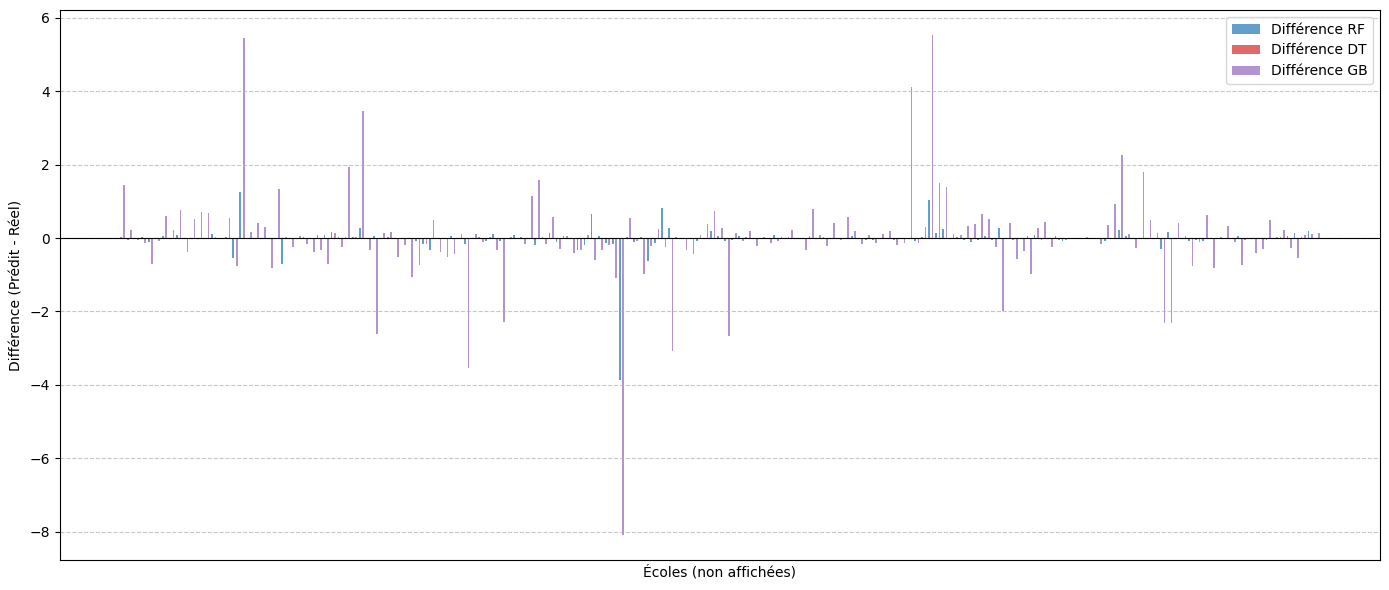

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np

# Colonnes explicatives pertinentes
features = [
    'note_brute_insertion_à_deux_mois',
    'note_brute_salaire_à_la_sortie',
    "note_brute_diplômés_en_poste_à_l'international",
    'note_brute_forums_entreprises',
    'note_brute_label_dd&rs',
    'note_brute_masse_et_encadrement_des_doctorants',
    'note_brute_moyenne_au_bac_des_intégrés',
    'note_brute_ouverture_sociale',
    'note_brute_parité_au_sein_de_la_promotion_(hommes/femmes)',
    "note_brute_part_d'enseignants-chercheurs",
    'note_brute_politique_de_chaires',
    "note_brute_pourcentage_d'étudiants_internationaux",
    'note_brute_réputation_internationale',
    "note_brute_taux_d'alternants",
    'note_brute_étudiants_rémunérés_pendant_leurs_études',
]

# Préparation des données
X = df[features].apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

ecoles = df["ecole"] if "ecole" in df.columns else [f"École {i}" for i in range(len(df))]

y_proxy = df['note_brute_insertion_à_deux_mois'].fillna(df['note_brute_insertion_à_deux_mois'].mean())

# Pas de split ici puisque tu entraînes sur toutes les données

# Initialisation des modèles
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_dt = DecisionTreeRegressor(random_state=42)
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Entraînement
model_rf.fit(X, y_proxy)
model_dt.fit(X, y_proxy)

model_gb = HistGradientBoostingRegressor(random_state=42)
model_gb.fit(X, y_proxy)


# Prédictions
y_pred_rf = model_rf.predict(X)
y_pred_dt = model_dt.predict(X)
y_pred_gb = model_gb.predict(X)

# Affichage des prédictions
print(f"{'École':30} | {'RF 6 mois':>10} | {'DT 6 mois':>10} | {'GB 6 mois':>10} | {'Insertion 2 mois (réel)':>20}")
print("-"*90)
for nom_ecole, pred_rf, pred_dt, pred_gb in zip(ecoles, y_pred_rf, y_pred_dt, y_pred_gb):
    vrai_2_mois = df.loc[df['ecole'] == nom_ecole, 'note_brute_insertion_à_deux_mois'].values
    vrai_2_mois = vrai_2_mois[0] if len(vrai_2_mois) > 0 else None
    print(f"{nom_ecole:30} | {pred_rf:10.2f} | {pred_dt:10.2f} | {pred_gb:10.2f} | {str(vrai_2_mois):>20}")

# Vraies valeurs pour correspondre aux écoles
vrais_2_mois = []
for nom_ecole in ecoles:
    val = df.loc[df['ecole'] == nom_ecole, 'note_brute_insertion_à_deux_mois'].values
    vrais_2_mois.append(val[0] if len(val) > 0 else np.nan)

x = np.arange(len(ecoles))
width = 0.25

# Calcul des différences pour chaque modèle
differences_rf = np.array(y_pred_rf) - np.array(vrais_2_mois)
differences_dt = np.array(y_pred_dt) - np.array(vrais_2_mois)
differences_gb = np.array(y_pred_gb) - np.array(vrais_2_mois)

plt.figure(figsize=(14, 6))

plt.bar(x - width, differences_rf, width, label='Différence RF', color='tab:blue', alpha=0.7)
plt.bar(x, differences_dt, width, label='Différence DT', color='tab:red', alpha=0.7)
plt.bar(x + width, differences_gb, width, label='Différence GB', color='tab:purple', alpha=0.7)

plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Différence (Prédit - Réel)')
plt.xlabel('Écoles (non affichées)')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ne pas afficher les labels x pour plus de lisibilité
plt.xticks([])

plt.tight_layout()
plt.show()
